In [31]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import datasets
import matplotlib
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [32]:
talks_df = pd.read_pickle('/home/p1dg/retrival_bot/data/datasets/prepaired_data.df")
talks_df.sample(10)

,Season,Episode,speaker,query,companions,close_reply,neutral_reply,bad_reply,context
9897,Season 3,Episode 8,daenerys targaryen,Athjahaka.,"[yara greyjoy, theon greyjoy, yara greyjoy, th...","[I know., You don't know., Why did you come he...","[The Queen in the North!, After a long consult...","[Don't call them that., A letter for you, Lord...",Look at me. Look at me! Men died trying to res...
21765,Season 7,Episode 5,jon snow,You're a lot leaner.,[],[],"[You're a lot shorter., You're a lot leaner., ...","[Can you leave the war for one night?, You are...",
10229,Season 3,Episode 9,robb stark,I suppose it does seem strange from a foreigne...,"[jon snow, tormund, jon snow, tormund]",[That's what'll happen to you if we lose. The ...,"[The Queen in the North!, After a long consult...","[I am not your enemy. The dead are the enemy.,...","But you should leave, Grandmother. Your place ..."
3568,Season 2,Episode 2,theon greyjoy,I'm his only living son. He'll listen to me.,"[tyrion lannister, man, tyrion lannister, cers...","[Pod, my helmet. Ser Mandon, you will bear the...","[You don't want Balon Greyjoy for an ally., Yo...",[And yet you really want to say. You want to s...,What did my mother say exactly? Did she have u...
8912,Season 3,Episode 6,sam,Not so far. A few more days.,"[gilly, sam, gilly, sam]",[Just promise me that whatever happens you'll ...,"[What did you say to him?, What do your captai...","[True. But I'm not a Stark., And he's headed t...",The next time you see something like that you ...
17087,Season 5,Episode 10,sparrow,You wish to make a confession?,[],[],"[Once I've confessed, will I be free?, And you...","[What is there to tell?, You must be weary aft...",
4488,Season 2,Episode 4,petyr baelish,Both girls are healthy and safe. For now. But ...,"[tyrion lannister, varys, tyrion lannister, va...","[I hope we might speak. In confidence., Oh, al...","[What kind do you want to be?, What do you wan...",[We'll be together again soon and everything w...,How many of those fingers do you think we coul...
967,Season 1,Episode 4,theon greyjoy,Really? If I was cooped up all day with no one...,"[eddard stark, petyr baelish, eddard stark, ca...","[I don't have the time., It won't take more th...","[I don't want to go., I want to go with you., ...","[This is Daenerys Targaryen, the Stormborn, th...",I'll go ahead with my daughters. Get them read...
6237,Season 2,Episode 8,tyrion lannister,You've forgotten the most important thing abou...,"[shae, tyrion lannister, shae, tyrion lannister]",[I'm not afraid of them. I'm not going to run....,"[Oh? Well, you're the expert. Tell me., Your q...","[Did I seem scared the other day?, Where are y...",You don't want her.. By our children.. What ar...
465,Season 1,Episode 2,catelyn stark,I don't care about appointments!,"[cersei lannister, joffrey lannister, cersei l...","[A royal army?, Why should every lord command ...","[When was the last time you left this room?, M...",[Meynard says here that he issued an anullment...,Yes. She's very beautiful and young. If you do...


In [33]:
# Соберем все ответы из базы
base_answers = talks_df["close_reply"].values
all_replies = []
for rep in base_answers.tolist():
    all_replies.extend(rep)
all_replies = list(set(all_replies))  # Список всех ответов из базы

In [34]:
from typing import Callable, Iterable

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [35]:
SEED = 10

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [36]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
bert_model.from_pretrained("sbert_softmax_lr_0.0")

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [37]:
tokenized_texts = tokenizer(
    ["I am hungry."], ["Order some food for me"], padding=True, truncation=True
)
tokenizer.decode(tokenized_texts["input_ids"][0])

'[CLS] i am hungry. [SEP] order some food for me [SEP]'

In [38]:
dataset = datasets.load_dataset("glue", "stsb", split="train")
len(dataset), dataset[0]

(5749,
 {'sentence1': 'A plane is taking off.',
  'sentence2': 'An air plane is taking off.',
  'label': 5.0,
  'idx': 0})

In [39]:
text_lengths1, text_lengths2 = [], []
for data in tqdm(dataset):
    if random.random() > 0.5:
        text_lengths1.append(len(data["sentence1"]))
        text_lengths2.append(len(data["sentence2"]))

100%|██████████| 5749/5749 [00:00<00:00, 45066.83it/s]


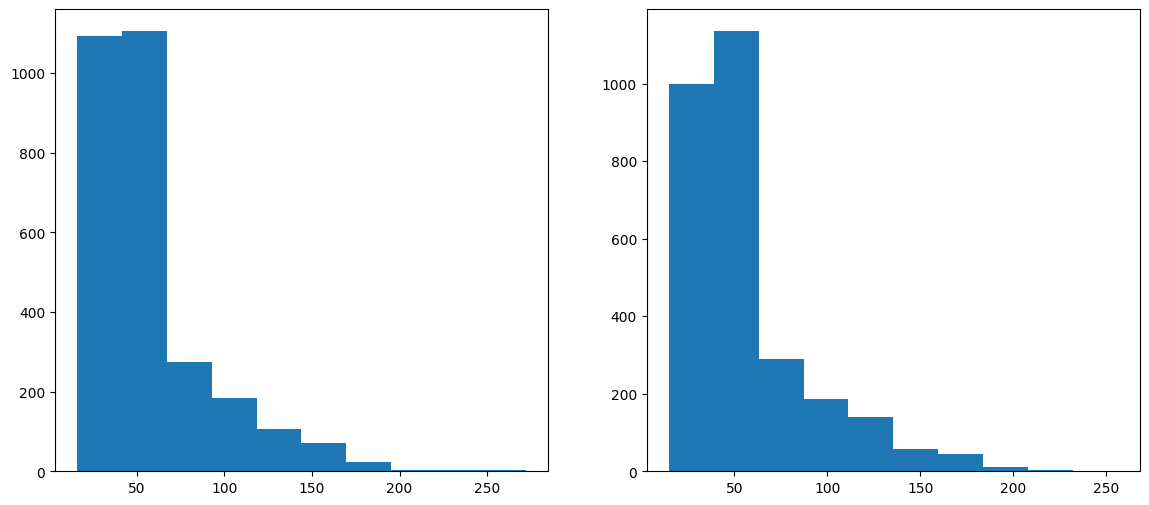

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(text_lengths1)
ax[1].hist(text_lengths2);

In [41]:
%%time

MAX_LENGTH = 128

tokenized_texts = tokenizer(
    [data["sentence1"] for data in dataset],
    [data["sentence2"] for data in dataset],
    max_length=MAX_LENGTH,
    padding="max_length",
    truncation=True,
    verbose=True,
)

CPU times: user 721 ms, sys: 368 ms, total: 1.09 s
Wall time: 498 ms


In [42]:
class StsDataset(Dataset):
    def __init__(self, tokens: dict, labels: list[float]):
        self.tokens = tokens
        self.labels = labels

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return {
            "input_ids": torch.tensor(self.tokens["input_ids"][ix], dtype=torch.long),
            "attention_mask": torch.tensor(
                self.tokens["attention_mask"][ix], dtype=torch.long
            ),
            "labels": torch.tensor(
                self.labels[ix], dtype=torch.float
            ),  # Use float for regression
        }

    def __len__(self) -> int:
        return len(self.tokens["input_ids"])

In [43]:
%%time

sts_dataset = StsDataset(tokenized_texts, [data["label"] for data in dataset])

CPU times: user 129 ms, sys: 62 µs, total: 129 ms
Wall time: 129 ms


In [44]:
train_ratio = 0.8
n_total = len(sts_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(sts_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [45]:
len(train_dataloader), len(val_dataloader)

(288, 72)

In [46]:
class CrossEncoderBert(torch.nn.Module):
    def __init__(self, max_length: int = MAX_LENGTH):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained("distilbert-base-uncased")
        self.bert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use the CLS token's output
        return self.linear(pooled_output)

In [47]:
model = CrossEncoderBert().to(DEVICE)

In [48]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps - warmup_steps,
)

loss_fn = torch.nn.MSELoss()

In [49]:
def train_step_fn(model, optimizer, scheduler, loss_fn, batch):
    model.train()
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    optimizer.zero_grad()
    logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    loss.backward()
    optimizer.step()
    scheduler.step()
    return loss.item()


def val_step_fn(model, loss_fn, batch):
    model.eval()
    input_ids = batch["input_ids"].to(DEVICE)
    attention_mask = batch["attention_mask"].to(DEVICE)
    labels = batch["labels"].to(DEVICE)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
    loss = loss_fn(logits.squeeze(-1), labels)
    return loss.item()


def mini_batch(dataloader, step_fn, is_training=True):
    mini_batch_losses = []
    for i, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        if is_training:
            loss = step_fn(model, optimizer, scheduler, loss_fn, batch)
        else:
            loss = step_fn(model, loss_fn, batch)
        mini_batch_losses.append(loss)
        if i % (batch_size * 4) == 0:
            print(f"Step {i:>5}/{len(dataloader)}, Loss = {loss:.3f}")
    return np.mean(mini_batch_losses), mini_batch_losses

In [50]:
%%time

n_epochs = 5

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch(
        train_dataloader, train_step_fn, is_training=True
    )
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(
            val_dataloader, val_step_fn, is_training=False
        )
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 1/288 [00:00<00:37,  7.71it/s]

Step     0/288, Loss = 11.450


 23%|██▎       | 67/288 [00:04<00:13, 16.27it/s]

Step    64/288, Loss = 1.509


 45%|████▌     | 131/288 [00:08<00:10, 14.81it/s]

Step   128/288, Loss = 0.777


 68%|██████▊   | 195/288 [00:12<00:05, 17.80it/s]

Step   192/288, Loss = 0.482


 90%|████████▉ | 259/288 [00:16<00:01, 16.99it/s]

Step   256/288, Loss = 0.615


 10%|▉         | 7/72 [00:00<00:01, 64.61it/s]

Step     0/72, Loss = 0.635


100%|██████████| 72/72 [00:01<00:00, 52.53it/s]


Step    64/72, Loss = 0.983

Epoch 2


  0%|          | 0/288 [00:00<?, ?it/s]

Step     0/288, Loss = 0.637


 24%|██▎       | 68/288 [00:03<00:13, 16.66it/s]

Step    64/288, Loss = 0.569


 46%|████▌     | 132/288 [00:07<00:09, 16.28it/s]

Step   128/288, Loss = 0.680


 68%|██████▊   | 196/288 [00:11<00:05, 16.09it/s]

Step   192/288, Loss = 0.752


 90%|█████████ | 260/288 [00:15<00:01, 15.47it/s]

Step   256/288, Loss = 1.169


  8%|▊         | 6/72 [00:00<00:01, 51.00it/s]

Step     0/72, Loss = 0.635


100%|██████████| 72/72 [00:01<00:00, 49.57it/s]


Step    64/72, Loss = 0.983

Epoch 3


  1%|▏         | 4/288 [00:00<00:18, 15.06it/s]

Step     0/288, Loss = 0.931


 24%|██▎       | 68/288 [00:04<00:13, 15.91it/s]

Step    64/288, Loss = 1.114


 46%|████▌     | 133/288 [00:07<00:07, 19.96it/s]

Step   128/288, Loss = 0.403


 68%|██████▊   | 195/288 [00:11<00:05, 17.80it/s]

Step   192/288, Loss = 0.741


 90%|█████████ | 260/288 [00:15<00:01, 18.52it/s]

Step   256/288, Loss = 0.779


 17%|█▋        | 12/72 [00:00<00:01, 55.13it/s]

Step     0/72, Loss = 0.635


100%|██████████| 72/72 [00:01<00:00, 55.05it/s]


Step    64/72, Loss = 0.983

Epoch 4


  0%|          | 0/288 [00:00<?, ?it/s]

Step     0/288, Loss = 0.736


 24%|██▎       | 68/288 [00:04<00:13, 16.75it/s]

Step    64/288, Loss = 1.068


 46%|████▌     | 132/288 [00:08<00:10, 14.89it/s]

Step   128/288, Loss = 0.458


 67%|██████▋   | 194/288 [00:12<00:06, 14.44it/s]

Step   192/288, Loss = 0.530


 90%|████████▉ | 258/288 [00:17<00:02, 13.52it/s]

Step   256/288, Loss = 0.418


  7%|▋         | 5/72 [00:00<00:01, 43.22it/s]

Step     0/72, Loss = 0.635


100%|██████████| 72/72 [00:01<00:00, 42.43it/s]


Step    64/72, Loss = 0.983

Epoch 5


  1%|▏         | 4/288 [00:00<00:18, 15.57it/s]

Step     0/288, Loss = 0.247


 23%|██▎       | 66/288 [00:04<00:16, 13.54it/s]

Step    64/288, Loss = 0.482


 46%|████▌     | 132/288 [00:09<00:10, 14.69it/s]

Step   128/288, Loss = 0.468


 67%|██████▋   | 194/288 [00:13<00:06, 14.70it/s]

Step   192/288, Loss = 0.598


 90%|█████████ | 260/288 [00:17<00:01, 15.42it/s]

Step   256/288, Loss = 0.191


  7%|▋         | 5/72 [00:00<00:01, 46.00it/s]

Step     0/72, Loss = 0.635


100%|██████████| 72/72 [00:01<00:00, 50.62it/s]

Step    64/72, Loss = 0.983
CPU times: user 1min 37s, sys: 1.07 s, total: 1min 38s
Wall time: 1min 38s


In [51]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses) - window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i : i + window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses) - window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i : i + window_size]))

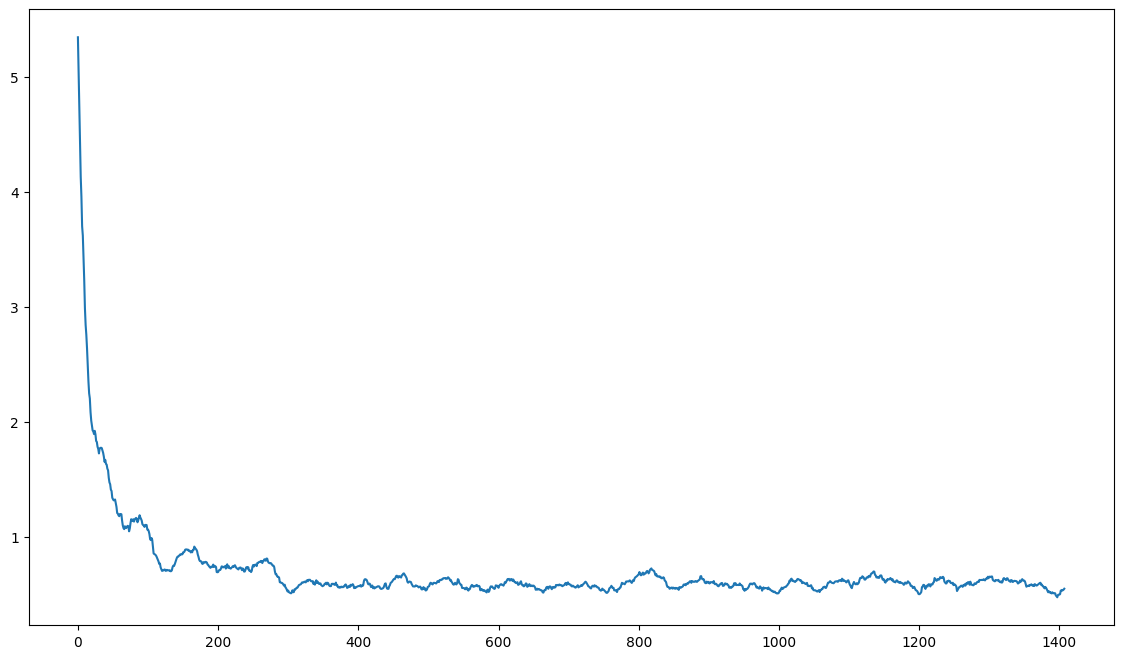

In [52]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [53]:
model.bert_model.save_pretrained("cross_ecoder_5ep")

In [54]:
def get_ranked_docs(
    tokenizer: AutoTokenizer,
    finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel,
    query: str,
    corpus: list[str],
) -> None:
    queries = [query] * len(corpus)
    tokenized_texts = tokenizer(
        queries,
        corpus,
        max_length=MAX_LENGTH,
        padding=True,
        truncation=True,
        return_tensors="pt",
    ).to(DEVICE)

    # Finetuned CrossEncoder model scoring
    with torch.no_grad():
        ce_scores = finetuned_ce(
            tokenized_texts["input_ids"], tokenized_texts["attention_mask"]
        ).squeeze(-1)
        ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

    # Base Bert model scoring
    with torch.no_grad():
        base_bert_outputs = base_bert(**tokenized_texts)
        bert_scores = torch.sigmoid(
            finetuned_ce.linear(base_bert_outputs.last_hidden_state[:, 0, :])
        )  # Use CLS token output

    # Process scores for finetuned model
    print(f"Query - {query} [Finetuned Cross-Encoder]\n---")
    scores = ce_scores.cpu().numpy()
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

    # Process scores for base Bert model
    print(f"\nQuery - {query} [Bert Base]\n---")
    scores = bert_scores.cpu().numpy().squeeze(-1)
    scores_ix = np.argsort(scores)[::-1]
    for ix in scores_ix:  # Limit to corpus size
        print(f"{scores[ix]: >.2f}\t{corpus[ix]}")

In [55]:
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]

query = "A man is eating pasta."

In [56]:
get_ranked_docs(tokenizer, model, bert_model.to(DEVICE), query, corpus)

Query - A man is eating pasta. [Finetuned Cross-Encoder]
---
0.93	A man is eating food.
0.89	A man is eating a piece of bread.
0.60	A man is riding a horse.
0.57	A man is riding a white horse on an enclosed ground.
0.57	A cheetah is running behind its prey.
0.56	Two men pushed carts through the woods.
0.52	The girl is carrying a baby.
0.50	A monkey is playing drums.
0.49	A woman is playing violin.

Query - A man is eating pasta. [Bert Base]
---
0.51	A man is eating food.
0.51	A man is eating a piece of bread.
0.50	Two men pushed carts through the woods.
0.50	A cheetah is running behind its prey.
0.50	A man is riding a horse.
0.49	The girl is carrying a baby.
0.49	A woman is playing violin.
0.49	A monkey is playing drums.
0.49	A man is riding a white horse on an enclosed ground.


In [57]:
def flush_memory():
    import gc

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    with torch.no_grad():
        for _ in range(3):
            torch.cuda.empty_cache()
            torch.cuda.ipc_collect()

In [58]:
def get_best_rand_reply(
    tokenizer: AutoTokenizer,
    finetuned_ce: CrossEncoderBert,
    base_bert: AutoModel,
    query: str,
    context: str,
    corpus: list[str],
    size_patch=150,
    qty_rand_choose=5,
    max_out_context=200,
) -> None:
    dic_answ = dict()
    dic_answ["score"] = []
    dic_answ["answer"] = []

    conext_memory = query + "[SEP]" + context

    if len(corpus) < qty_rand_choose * max_out_context:
        qty_rand_choose = int(len(corpus))

    # так как база большая
    for i in range(qty_rand_choose):
        rand_patch_corpus = list(np.random.choice(corpus, size_patch))
        # print(len(rand_patch_corpus))

        queries = [conext_memory] * len(rand_patch_corpus)
        # print(len(queries))
        tokenized_texts = tokenizer(
            queries,
            rand_patch_corpus,
            max_length=MAX_LENGTH,
            padding=True,
            truncation=True,
            return_tensors="pt",
        ).to(DEVICE)

        # Finetuned CrossEncoder model scoring
        with torch.no_grad():
            ce_scores = finetuned_ce(
                tokenized_texts["input_ids"], tokenized_texts["attention_mask"]
            ).squeeze(-1)
            ce_scores = torch.sigmoid(ce_scores)  # Apply sigmoid if needed

        # Process scores for finetuned model
        scores = ce_scores.cpu().numpy()
        scores_ix = np.argsort(scores)[::-1][0]
        dic_answ["score"].append(scores[scores_ix])
        dic_answ["answer"].append(rand_patch_corpus[scores_ix])

    id = np.argsort(dic_answ["score"])[::-1][0]  # np.array(dic_answ["score"]).argmax()
    answer = dic_answ["answer"][id]
    conext_memory = answer + "[SEP]" + conext_memory
    flush_memory()
    return answer, conext_memory[:max_out_context], dic_answ["score"][id]

In [59]:
question = "What is the live?"  #
print(f"Реплика: {question}")

best_answer, conext_memory, best_score = get_best_rand_reply(
    tokenizer,
    model,
    bert_model.to(DEVICE),
    query=question,
    context="",
    corpus=all_replies,
)

print(f"Лучший ответ: {best_answer}\nscore {best_score}")

Реплика: What is the live?
Лучший ответ: Oysters, clams, and cockels! Oysters, clams, and cockels! Oysters, clams, and cockels! Oysters, clams, and cock--
score 0.984527587890625


In [60]:
rand_questions = talks_df.sample(10)["query"].values

for i, question in enumerate(rand_questions):
    print(f"Реплика: {question}")
    if not i:
        conext_memory = ""
    best_answer, conext_memory, best_score = get_best_rand_reply(
        tokenizer,
        model,
        bert_model.to(DEVICE),
        query=question,
        context=conext_memory,
        corpus=all_replies,
    )
    best_score = round(float(best_score), 3)
    print(f"Ответ: {best_answer}\n score {best_score}\n")

Реплика: The raven's been coming to me ever since I fell from that tower. He wants me to find him. I don't have my legs anymore. This is what I have now.
Ответ: Last time we saw each other was at Winterfell, yes? You were making jokes about my height, I seem to recall. Everyone who makes a joke about a dwarf's height thinks he's the only person ever to make a joke about a dwarf's height. “The height of nobility,” “a man of your stature,” “someone to look up to.” You're all making the same five or six jokes.
 score 0.941

Реплика: Me, too, dear. Death is so boring, especially now with so much excitement in the world. . My Lady, I'm sorry for your loss.
Ответ: Joffrey. Cersei. llyn Payne. The Hound. Joffrey. Cersei. llyn Payne. The Hound. Joffrey. Cersei. llyn Payne. The Hound.
 score 0.944

Реплика: Would you like to walk without shoes?
Ответ: Oysters, clams, and cockels! Oysters, clams, and cockels! Oysters, clams, and cockels! Oysters, clams, and cock--
 score 0.979

Реплика: He will 